In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(purrr)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#download the heart and disease data from online 

hd_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",delim=",", col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) #assign the column name accordingly with the given column names from online data base
hd_data

                  

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0
32,1,2,110,225,0,0,184,0,0,?,?,?,0
32,1,2,125,254,0,0,155,0,0,?,?,?,0
33,1,3,120,298,0,0,185,0,0,?,?,?,0


In [15]:
#Choosing the predicting variables that we are going to use to predict the class type(avoid using slop,ca,thl because they have missing values)
set.seed(1234)
process_hd_data<-hd_data|>
#choosing the predicting variables and class variable
select(c(age,chol,trestbps,thalach,oldpeak,num))|>
#filter out any missing values
filter(age!="?",chol!="?",trestbps!="?",thalach!="?",oldpeak!="?",num!="?")|>
#change the type of the data to factor because the class variable we predicting should be categorical
mutate(num=as.factor(num))|>
#change the type of the data to dbl because the predicting variables we predicting should be double
mutate(across(c(age, chol, trestbps, thalach, oldpeak), as.integer))|>
mutate(Prognosis= case_when(num == "0" ~ "negative",num == "1" ~ "positive"))|>
print(20)

process_hd_data

# A tibble: 270 × 7
     age  chol
   <int> <int>
 1    28   132
 2    29   243
 3    30   237
 4    31   219
 5    32   198
 6    32   225
 7    32   254
 8    33   298
 9    34   161
10    34   214
# ℹ 260 more rows
# ℹ 5 more
#   variables:
#   trestbps <int>,
#   thalach <int>,
#   oldpeak <int>,
#   num <fct>, …


age,chol,trestbps,thalach,oldpeak,num,Prognosis
<int>,<int>,<int>,<int>,<int>,<fct>,<chr>
28,132,130,185,0,0,negative
29,243,120,160,0,0,negative
30,237,170,170,0,0,negative
31,219,100,150,0,0,negative
32,198,105,165,0,0,negative
32,225,110,184,0,0,negative
32,254,125,155,0,0,negative
33,298,120,185,0,0,negative
34,161,130,190,0,0,negative


In [16]:
#pre-process the data by splitting into train/test set

train_test_split<-initial_split(process_hd_data, prop=0.70, strata=Prognosis) #Using 70% as training set and 30% as testing.
# Assign name to each set
train_set<-training(train_test_split)
test_set<-testing(train_test_split)

In [17]:
# calculates the lowest and maximum values for the train_set data frame's variables (age, chol, trestbps, thalach, and oldpeak). Then, we create a new data frame named summaryand puts the result inside. 
# we also count the percentages the number of observations for each level of the Prognosis variable in the process_hd_data data frame.
summary<- train_set |>
  summarize(across(c(age, chol, trestbps, thalach, oldpeak), list(min = min, max = max))) 

num_obs <- nrow(process_hd_data)
process_hd_data |>
group_by(Prognosis) |>
summarize(count = n(),percentage = n() / num_obs * 100)

summary

Prognosis,count,percentage
<chr>,<int>,<dbl>
negative,169,62.59259
positive,101,37.40741


age_min,age_max,chol_min,chol_max,trestbps_min,trestbps_max,thalach_min,thalach_max,oldpeak_min,oldpeak_max
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
29,65,85,529,92,180,87,190,0,5


`geom_smooth()` using formula = 'y ~ x'


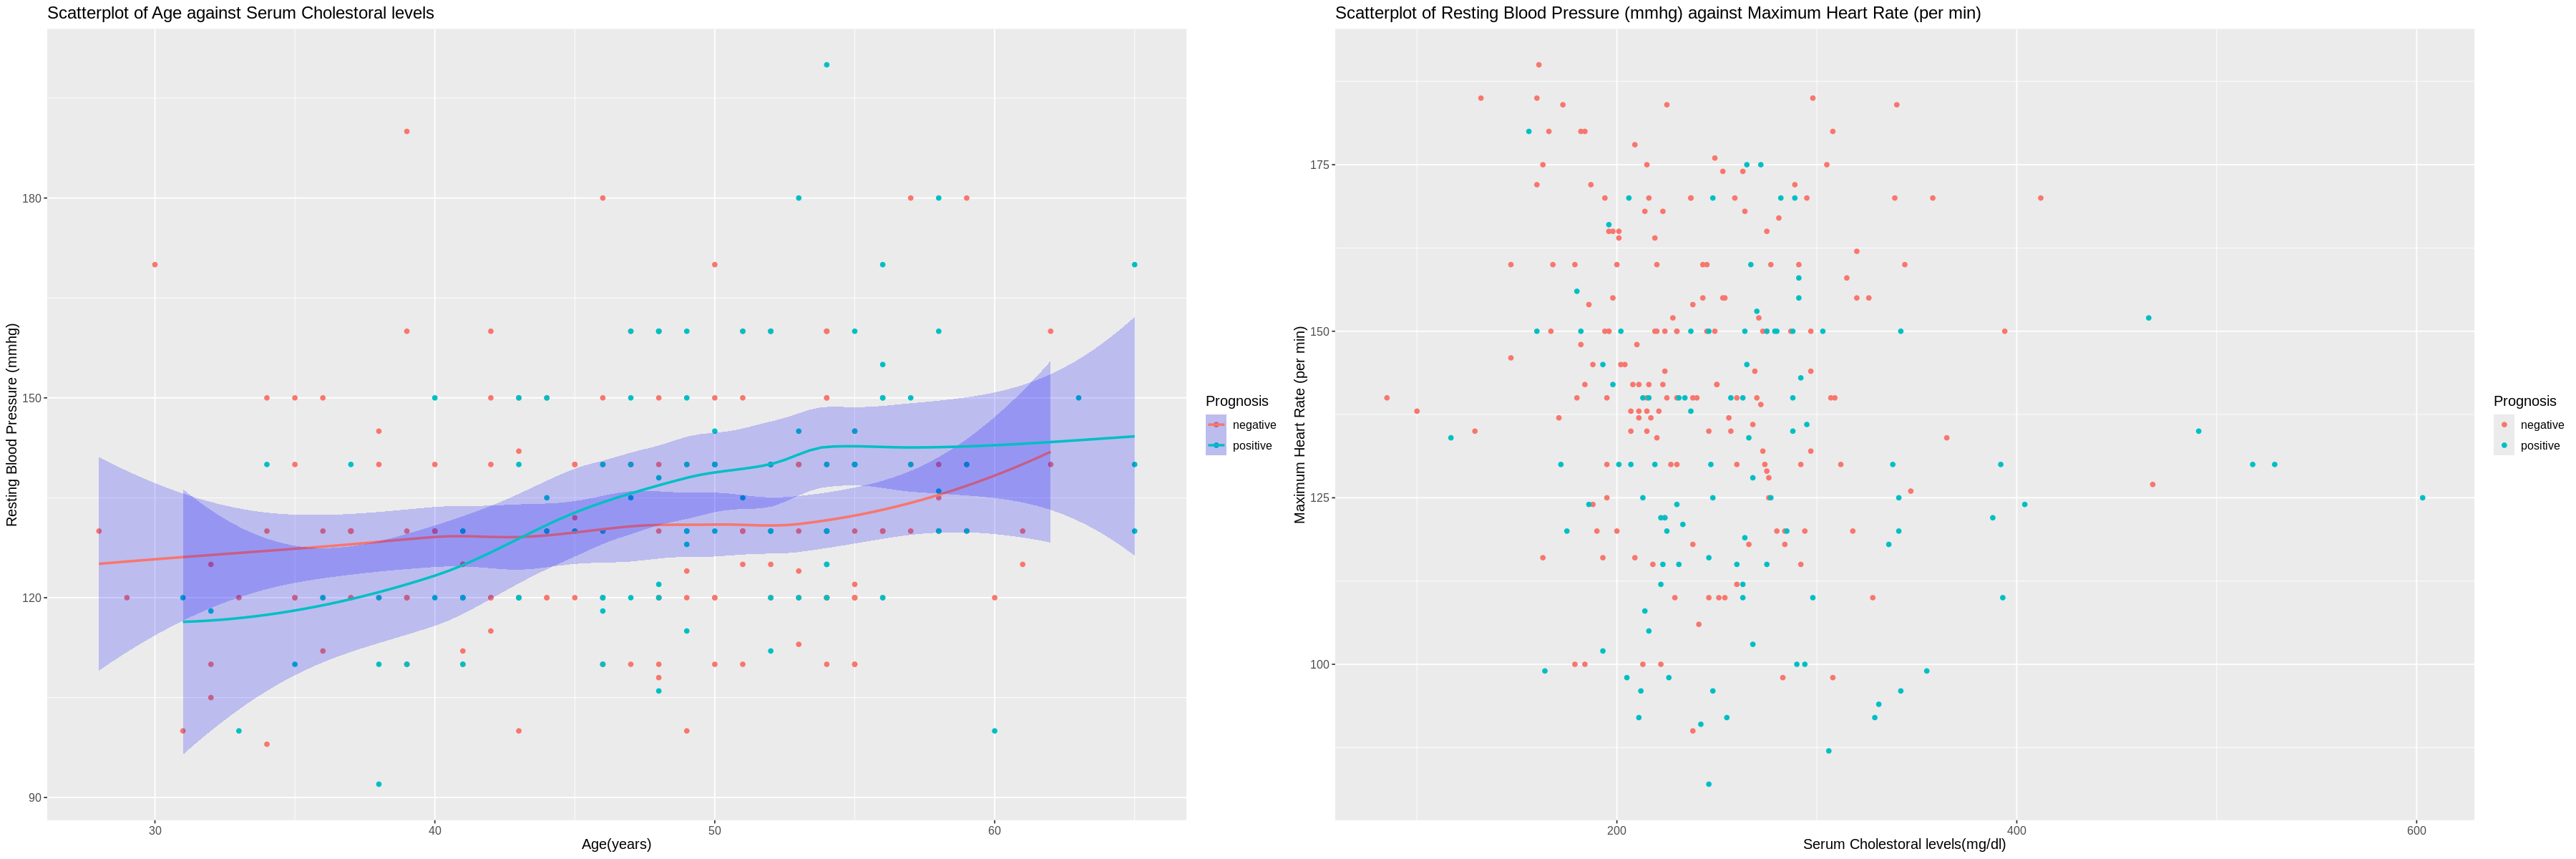

In [18]:
# create visualization of showing the distribution of Prognosis based on column that has high-variance in value 

library(ggplot2)
library(gridExtra)
options(repr.plot.width = 30, repr.plot.height = 10)

# Scatterplot for variable 'a'
plot_1 <- ggplot(process_hd_data, aes(x = age, y = trestbps, color = Prognosis)) +
  geom_point(alpha=3) +
  labs(title = "Scatterplot of Age against Serum Cholestoral levels",
       x = "Age(years)", y = "Resting Blood Pressure (mmhg)", color = "Prognosis") +
geom_smooth(method = "loess", fill = "blue", alpha = 0.2)+
  theme(text = element_text(size = 12))



# Scatterplot for variable 'c'
plot_2 <- ggplot(process_hd_data, aes(x = chol, y = thalach, color = Prognosis)) +
  geom_point(alpha=3) +
  labs(title = "Scatterplot of Resting Blood Pressure (mmhg) against Maximum Heart Rate (per min)",
       x = "Serum Cholestoral levels(mg/dl)", y = "Maximum Heart Rate (per min)", color = "Prognosis") +
  theme(text = element_text(size = 12))


grid.arrange(plot_1,plot_2, nrow = 1)


In [19]:
#Prevent randomlization of data
set.seed(1234)

#Creating standardized recipe
all_k_recipe <- recipe(Prognosis ~ trestbps+thalach+age+chol+oldpeak , data = train_set) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# building the basic model specification to auto-tune k value
all_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# fold 20 times for cross-validation
all_k_vfold<- vfold_cv(train_set, v = 20, strata = Prognosis)

kval <- tibble(neighbors = c(1:80))

# Workflow analysis
all_k_results <- workflow() |>
      add_recipe(all_k_recipe) |>
      add_model(all_k_spec) |>
      tune_grid(resamples = all_k_vfold, grid = kval)|>
#collecting matrix and filter the accuaracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

all_k_results


neighbors,mean
<int>,<dbl>
23,0.7877778
24,0.7877778
51,0.7877778
52,0.7877778
55,0.7877778
56,0.7877778
33,0.7876389
34,0.7876389
35,0.7876389


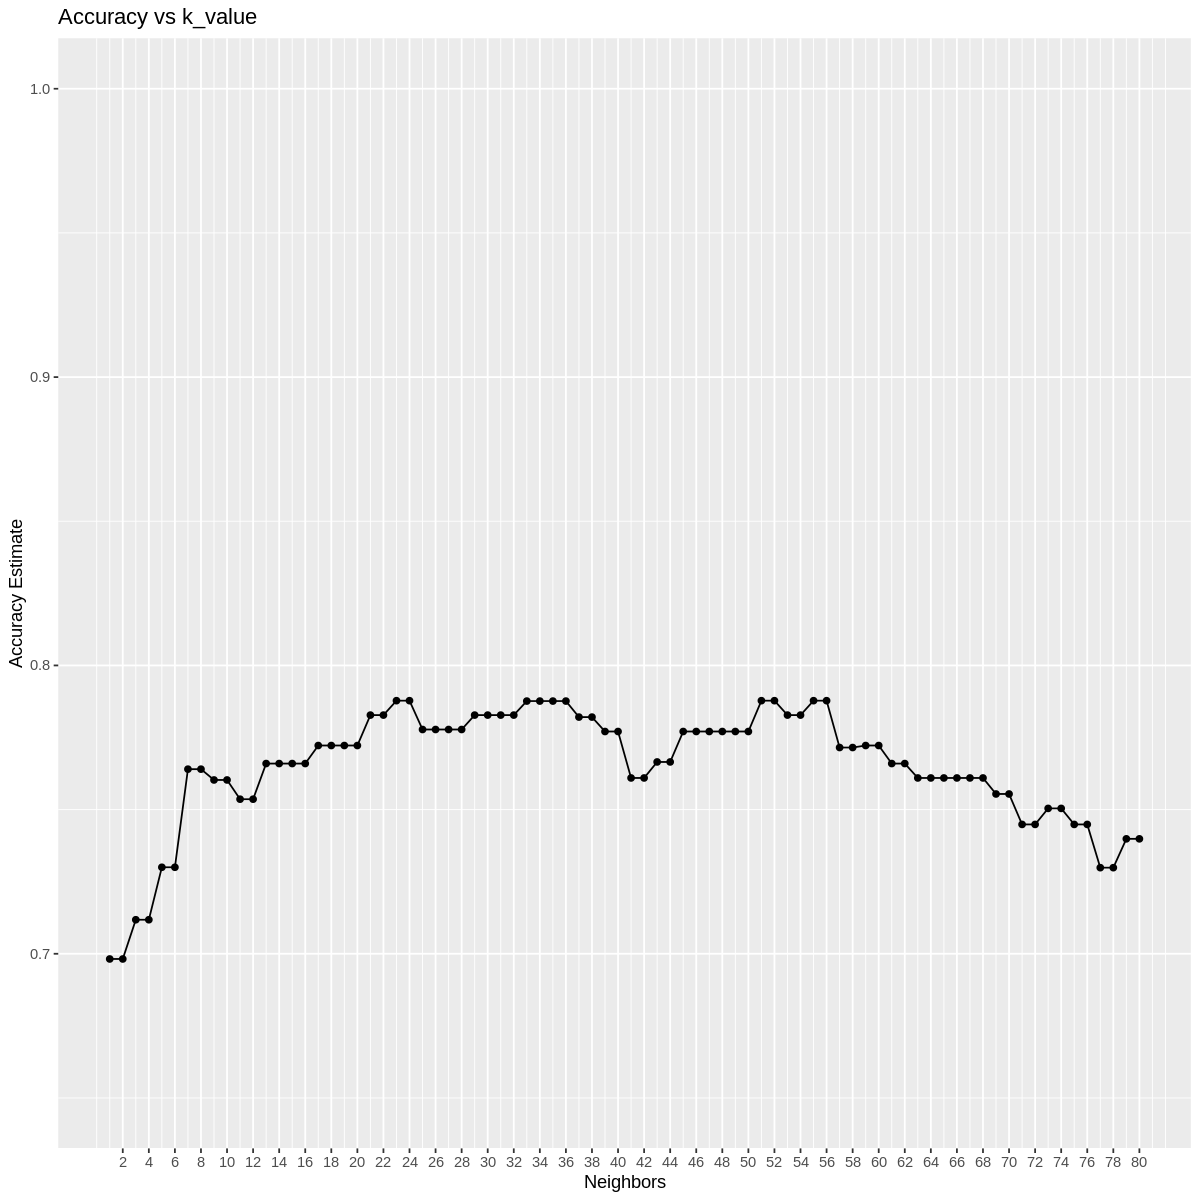

In [20]:
#ploting the K_Value vs Accuracy graph
k_val_plot <- 
       ggplot(all_k_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate",title="Accuracy vs k_value") +
       scale_x_continuous(breaks = seq(2, 80, by = 2)) +  
       scale_y_continuous(limits = c(0.65, 1.0)) 
options(repr.plot.width = 10, repr.plot.height = 10)
k_val_plot

In [21]:
# According to table, choose when k=31 or 30 where the accuracy is at most 0.80
#verify
best_k <- all_k_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 23

In [22]:
#Use the best k_value k=37 to build final model
best_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors = best_k)|>
    set_engine("kknn")|>
    set_mode("classification")

best_k_workflow<-workflow()|>
    add_recipe(all_k_recipe)|>
    add_model(best_k_spec)|>
    fit(data = train_set)

best_k_workflow
    

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.212766
Best kernel: rectangular
Best k: 23

In [23]:
#Test the classifier

set.seed(1234)


test_pred <- predict(best_k_workflow, test_set) |>
               bind_cols(test_set)



# Convert Prognosis column to factor
test_pred$Prognosis <- as.factor(test_pred$Prognosis)




#Build metrics for precisions
result_matrics<- test_pred|>
    metrics(truth = Prognosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
result_matrics

#Build confusion matrics for further understanding


conf_mat<- test_pred |>
    conf_mat(truth = Prognosis, estimate = .pred_class)
conf_mat
#Produce precision and recall matrix
recall1<-test_pred |>
    recall(truth = Prognosis, estimate = .pred_class, event_level="first")


predictions1<-test_pred |>
    precision(truth = Prognosis, estimate = .pred_class, event_level="first")

combined_results <- bind_rows(recall1, predictions1)
combined_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7317073


          Truth
Prediction negative positive
  negative       48       19
  positive        3       12

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9411765
precision,binary,0.7164179


In [24]:
#Testing model on cleveland 

cle_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                      col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

cle_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


In [25]:
#reprocess our data so that num column has class value of 1 and 2
new<-cle_data|>
mutate(num = ifelse(num != 0, 1, num))
head(new)

#Choosing the predicting variables that we are going to use to predict the class type(avoid using slop,ca,thl because they have missing values)
process_cl_data<-new|>
#choosing the predicting variables and class variable
select(c(age,chol,trestbps,thalach,oldpeak,num))|>
#filter out any missing values
filter(age!="?",chol!="?",trestbps!="?",thalach!="?",oldpeak!="?",num!="?")|>
#change the type of the data to factor because the class variable we predicting should be categorical
mutate(num=as.factor(num))|>
#change the type of the data to dbl because the predicting variables we predicting should be double
mutate(across(c(age, chol, trestbps, thalach, oldpeak), as.integer))|>
mutate(Prognosis= case_when(num == "0" ~ "negative",num == "1" ~ "positive"))
process_cl_data$oldpeak <- round(process_cl_data$oldpeak)
print(20)

head(process_cl_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 20


age,chol,trestbps,thalach,oldpeak,num,Prognosis
<int>,<int>,<int>,<int>,<dbl>,<fct>,<chr>
63,233,145,150,2,0,negative
67,286,160,108,1,1,positive
67,229,120,129,2,1,positive
37,250,130,187,3,0,negative
41,204,130,172,1,0,negative
56,236,120,178,0,0,negative


In [26]:
#Apply hungarian data on cleveland data set

cle_pred <- predict(best_k_workflow, process_cl_data)|>
                      bind_cols(process_cl_data)

cle_pred
# Convert Prognosis column to factor
cle_pred$Prognosis <- as.factor(cle_pred$Prognosis)




#Build metrics for precisions
cle_matrics<- cle_pred|>
    metrics(truth = Prognosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
cle_matrics
#Build confusion matrics for further understanding


cle_conf_mat<- cle_pred |>
    conf_mat(truth = Prognosis, estimate = .pred_class)
cle_conf_mat
#Produce precision and recall matrix
recall2<-cle_pred |>
    recall(truth = Prognosis, estimate = .pred_class, event_level="second")


predictions2<-cle_pred |>
    precision(truth = Prognosis, estimate = .pred_class, event_level="second")

cle_combined_results <- bind_rows(recall2, predictions2)
cle_combined_results

.pred_class,age,chol,trestbps,thalach,oldpeak,num,Prognosis
<fct>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<chr>
positive,63,233,145,150,2,0,negative
positive,67,286,160,108,1,1,positive
positive,67,229,120,129,2,1,positive
positive,37,250,130,187,3,0,negative
negative,41,204,130,172,1,0,negative
negative,56,236,120,178,0,0,negative
positive,62,268,140,160,3,1,positive
negative,57,354,120,163,0,0,negative
negative,63,254,130,147,1,1,positive


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7128713


          Truth
Prediction negative positive
  negative      156       79
  positive        8       60

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4316547
precision,binary,0.8823529
